In [ ]:
#Mounting Drive for accessing test and train data
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#importing necessary libraries for making the models and loading images 
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import os
import numpy as np
from PIL import Image
import matplotlib.image as mpimg 
import matplotlib.cm as cm
import IPython.display
import codecs
import json
import cv2

In [ ]:
#tensor flow image directory function for separating training set
#taking images in rgb format
#seed value for shuffling the images
#using half the data set for training 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/drive/My Drive/Train',
  validation_split=0.5,
  subset='training',
  seed=123,
  color_mode='rgb',
  image_size=(200, 200),
  batch_size=32)

Found 29000 files belonging to 29 classes.
Using 14500 files for training.


In [ ]:
#same function as the one used above
#this one is used for validation data set, which is 20% of the training set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/drive/My Drive/Train',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(200, 200),
  batch_size=32)

Found 29000 files belonging to 29 classes.
Using 5800 files for validation.


In [ ]:
#Printing the class names 
#Used in predicting, for realizing the actuall label predicted for each image
class_names = train_ds.class_names
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


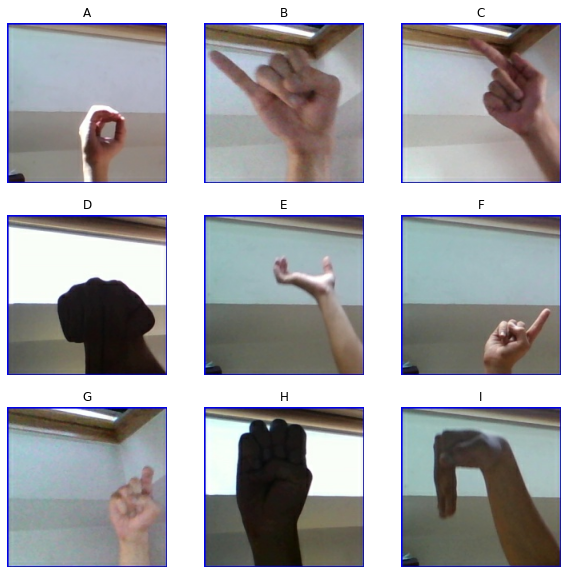

In [ ]:
#Visual representation of the dataset to show the images 
#Images are shown along with the class that they belong to
#Images are in rgb
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

In [ ]:
#Printing the shape of the batches in the train and validation dataset
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 200, 200, 3)
(32,)


In [ ]:
#Auto tuning the data for better performance
#This optimizes the time in which the model fits the data  
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
print(train_ds)

<PrefetchDataset shapes: ((None, 200, 200, 3), (None,)), types: (tf.float32, tf.int32)>


In [ ]:
#The first model 
#A simpler model to see how it performs on the data set without much preprocessing
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(200, 200, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(29)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
363/363 [==============================] - 771s 57ms/step - loss: 2.6049 - accuracy: 0.2470 - val_loss: 1.6144 - val_accuracy: 0.4971
Epoch 2/15
363/363 [==============================] - 10s 28ms/step - loss: 1.0741 - accuracy: 0.6491 - val_loss: 0.7936 - val_accuracy: 0.7426
Epoch 3/15
363/363 [==============================] - 10s 28ms/step - loss: 0.4965 - accuracy: 0.8334 - val_loss: 0.5404 - val_accuracy: 0.8193
Epoch 4/15
363/363 [==============================] - 10s 28ms/step - loss: 0.2776 - accuracy: 0.9060 - val_loss: 0.5732 - val_accuracy: 0.8224
Epoch 5/15
363/363 [==============================] - 10s 28ms/step - loss: 0.1603 - accuracy: 0.9470 - val_loss: 0.4172 - val_accuracy: 0.8869
Epoch 6/15
363/363 [==============================] - 10s 28ms/step - loss: 0.1139 - accuracy: 0.9620 - val_loss: 0.4996 - val_accuracy: 0.8748
Epoch 7/15
363/363 [==============================] - 10s 28ms/step - loss: 0.0817 - accuracy: 0.9728 - val_loss: 0.5023 - val_accuracy

In [ ]:
img_height=200
img_width=200
batch_size=32

In [ ]:
#To get better results from the we use data augmentation
#Used to change the images slightly so that there's more data for the model to learn from
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

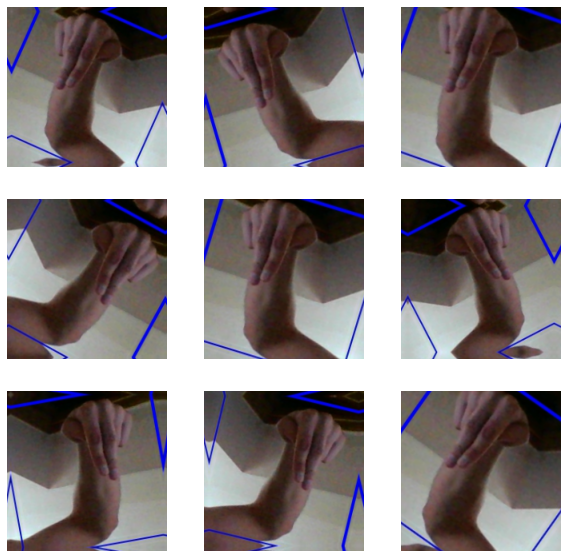

In [ ]:
#Visualization of the data augmentation shows how a single image is changed by rotating it to sides by different amounts
#By doing this the model has more data related to images to learn from and perform better 
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
#Second model which is slightly more complex from the first model and uses the augmented data 
#Gives a better performance due to data augmentation
newmodel = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(29)
])
newmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 15
history = newmodel.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
363/363 [==============================] - 13s 32ms/step - loss: 3.0246 - accuracy: 0.1278 - val_loss: 2.3161 - val_accuracy: 0.2872
Epoch 2/15
363/363 [==============================] - 11s 32ms/step - loss: 2.0149 - accuracy: 0.3759 - val_loss: 1.5383 - val_accuracy: 0.5107
Epoch 3/15
363/363 [==============================] - 11s 32ms/step - loss: 1.5493 - accuracy: 0.5013 - val_loss: 1.2141 - val_accuracy: 0.5959
Epoch 4/15
363/363 [==============================] - 11s 32ms/step - loss: 1.2681 - accuracy: 0.5814 - val_loss: 0.9987 - val_accuracy: 0.6731
Epoch 5/15
363/363 [==============================] - 11s 32ms/step - loss: 1.0733 - accuracy: 0.6422 - val_loss: 0.8235 - val_accuracy: 0.7219
Epoch 6/15
363/363 [==============================] - 11s 31ms/step - loss: 0.9200 - accuracy: 0.6891 - val_loss: 0.9337 - val_accuracy: 0.6828
Epoch 7/15
363/363 [==============================] - 11s 31ms/step - loss: 0.8248 - accuracy: 0.7188 - val_loss: 0.8496 - val_accuracy:

In [ ]:
#3rd model which performs the best due to its slightly more complexity and self set learning rate
#This is the model chosen for evaluation on the test set
opt=keras.optimizers.Adam(learning_rate=0.001)
umodel = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dense(29)
])
umodel.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 50
history = umodel.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
454/454 [==============================] - 74s 53ms/step - loss: 2.9364 - accuracy: 0.1254 - val_loss: 2.3691 - val_accuracy: 0.2584
Epoch 2/50
454/454 [==============================] - 14s 31ms/step - loss: 2.0950 - accuracy: 0.3180 - val_loss: 1.5665 - val_accuracy: 0.4603
Epoch 3/50
454/454 [==============================] - 14s 30ms/step - loss: 1.5322 - accuracy: 0.4752 - val_loss: 1.1506 - val_accuracy: 0.5966
Epoch 4/50
454/454 [==============================] - 14s 30ms/step - loss: 1.1764 - accuracy: 0.5919 - val_loss: 0.7693 - val_accuracy: 0.7295
Epoch 5/50
454/454 [==============================] - 14s 31ms/step - loss: 0.9717 - accuracy: 0.6606 - val_loss: 0.6757 - val_accuracy: 0.7690
Epoch 6/50
454/454 [==============================] - 14s 31ms/step - loss: 0.8295 - accuracy: 0.7085 - val_loss: 0.5774 - val_accuracy: 0.8000
Epoch 7/50
454/454 [==============================] - 14s 31ms/step - loss: 0.7072 - accuracy: 0.7461 - val_loss: 0.6169 - val_accuracy:

In [ ]:
#early stopping model for better optimization of the models and to learn about the optimum epoch number
opt=keras.optimizers.Adam(learning_rate=0.001)
es_model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dense(29)
])
es_model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Training using earlystopping
# Training will stop when minimum validation loss is achieved
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=10, 
                    verbose=1, mode='min',restore_best_weights=True) 

es_model.fit(train_ds,validation_data=val_ds, batch_size=32, epochs=100, callbacks=[es], verbose=1)

Epoch 1/100
272/272 [==============================] - 1862s 3s/step - loss: 3.3032 - accuracy: 0.0536 - val_loss: 3.0170 - val_accuracy: 0.1231
Epoch 2/100
272/272 [==============================] - 9s 33ms/step - loss: 2.6418 - accuracy: 0.1909 - val_loss: 2.2632 - val_accuracy: 0.2697
Epoch 3/100
272/272 [==============================] - 9s 33ms/step - loss: 2.0687 - accuracy: 0.3326 - val_loss: 1.6130 - val_accuracy: 0.4581
Epoch 4/100
272/272 [==============================] - 9s 33ms/step - loss: 1.6001 - accuracy: 0.4649 - val_loss: 1.2677 - val_accuracy: 0.5531
Epoch 5/100
272/272 [==============================] - 9s 33ms/step - loss: 1.3103 - accuracy: 0.5560 - val_loss: 1.0847 - val_accuracy: 0.6086
Epoch 6/100
272/272 [==============================] - 9s 33ms/step - loss: 1.0877 - accuracy: 0.6254 - val_loss: 0.9066 - val_accuracy: 0.6871
Epoch 7/100
272/272 [==============================] - 9s 33ms/step - loss: 0.9785 - accuracy: 0.6572 - val_loss: 0.7167 - val_accuracy

In [ ]:
#Function for reading the images from the test sets and predicting the classes
#Implementation is done by evaluating each image one by one so and results are printed to console
#The data fram is also created here for the predictions
import pandas as pd

imagename=[]
letter=[]
scorepred=[]
testset_images=[]
path='/content/drive/My Drive/test2'
folders=os.listdir(path)
folders=set(folders)
count=0
sum=0
for i in folders:
    print('***',i,'***')
    subject=path+'/'+i
    subdir=os.listdir(subject)
    subdir=set(subdir)
    for k in subdir:
      count+=1
      imagename.append(int(k.replace('.jpg','')))
      path= subject+'/'+k
      img = keras.preprocessing.image.load_img(
      path, target_size=(img_height, img_width))
      img_array = keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0) # Create a batch
      predictions = umodel.predict(img_array)
      score = tf.nn.softmax(predictions[0])
      sum+=(np.max(score)*100)
      scorepred.append(np.max(score)*100)
      letter.append(class_names[np.argmax(score)])
      print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))

print("Total Images:",count)
print("Accuracy of predictions is:",(sum/count))
tupleslist=list(zip(imagename,letter))
df=pd.DataFrame(tupleslist,columns=['Id','Prediction'])

Streaming output truncated to the last 5000 lines.
This image most likely belongs to O with a 61.91 percent confidence.
This image most likely belongs to nothing with a 100.00 percent confidence.
This image most likely belongs to U with a 100.00 percent confidence.
This image most likely belongs to W with a 100.00 percent confidence.
This image most likely belongs to U with a 95.89 percent confidence.
This image most likely belongs to H with a 100.00 percent confidence.
This image most likely belongs to B with a 100.00 percent confidence.
This image most likely belongs to Y with a 76.80 percent confidence.
This image most likely belongs to R with a 99.98 percent confidence.
This image most likely belongs to K with a 99.99 percent confidence.
This image most likely belongs to L with a 100.00 percent confidence.
This image most likely belongs to O with a 100.00 percent confidence.
This image most likely belongs to D with a 100.00 percent confidence.
This image most likely belongs to V wi

In [ ]:
#loading the test labels for test 2 data set in order to evaluate the prediction score
test2labels = np.load('/content/drive/My Drive/labels.npy')

In [ ]:
print(test2labels)

['J' 'W' 'J' ... 'T' 'Z' 'U']


In [ ]:
df.head(15)

,Id,Prediction
0,6485,X
1,8909,K
2,10517,P
3,8915,L
4,7751,C
5,5665,R
6,3674,J
7,4122,G
8,1562,N
9,9870,B


In [ ]:
len(df.index)

14500

In [ ]:
AAAAAAAAAAAAAAAAAAAAAAAAZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ

In [ ]:
#Sorting the data frame according to Id values so that they are in the correct format for the prediction score
df=df.sort_values(by='Id')
df.head(15)

,Id,Prediction
2249,0,J
14337,1,W
12513,2,J
8850,3,M
4164,4,M
6623,5,R
7169,6,K
12862,7,X
1323,8,Q
2812,9,K


In [ ]:
#evaluation of predictions with test 2 labels
#getting final score for the predictions made by the model
correct=0
for i in range(len(df.index)):
  if (df.iloc[i]['Prediction']==test2labels[i]):
    correct+=1

acc=correct/len(df.index)
print("Accuracy of predictions with test set 2 labels:", acc*100)

Accuracy of predictions with test set 2 labels: 97.08965517241379


In [ ]:
#downloading the data frame as csv file for submission
from google.colab import files

df.to_csv('submissiontest2.csv',index=False)
files.download('submissiontest2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>